In [1]:
#!pip install shap
#!conda install -c conda-forge shap
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn.linear_model
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics
import sklearn.inspection
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier


#import shap



plt.rcParams["figure.figsize"] = (8, 4.5)
plt.rcParams["figure.dpi"] = 120

# display pandas output so it's legible
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [2]:
#!pip install shap
import shap
np.__version__


'2.2.6'

In [3]:
PROJECT_ROOT = os.path.abspath(".")
print("Project root:", PROJECT_ROOT)
print("Top-level contents:", os.listdir(PROJECT_ROOT))

# Data folders
uci_path = os.path.join(PROJECT_ROOT, "UCI", "UCI_Online_Pop.csv")

mind_train_news_path = os.path.join(PROJECT_ROOT, "MINDsmall_train", "train_news.tsv")
mind_train_behaviors_path = os.path.join(PROJECT_ROOT, "MINDsmall_train", "train_behaviors.tsv")

mind_dev_news_path = os.path.join(PROJECT_ROOT, "MINDsmall_dev", "dev_news.tsv")
mind_dev_behaviors_path = os.path.join(PROJECT_ROOT, "MINDsmall_dev", "dev_behaviors.tsv")



Project root: C:\Users\Evan\Desktop\Capstone
Top-level contents: ['.ipynb_checkpoints', 'dev_behaviors.tsv', 'dev_news.tsv', 'figs', 'McLaughlin_Capstone_v1.ipynb', 'MINDsmall_dev', 'MINDsmall_train', 'mind_tfidf_baseline_metrics.png', 'train_behaviors.tsv', 'train_news.tsv', 'UCI', 'Untitled.ipynb']


In [4]:
fig_dir = os.path.join(PROJECT_ROOT, "figs")
os.makedirs(fig_dir, exist_ok=True)
print("Figures will be saved to:", fig_dir)

# Quick check
for p in [uci_path,
          mind_train_news_path, mind_train_behaviors_path,
          mind_dev_news_path, mind_dev_behaviors_path]:
    print(f"{os.path.basename(p):25s} -> {'OK' if os.path.exists(p) else 'MISSING'}")


Figures will be saved to: C:\Users\Evan\Desktop\Capstone\figs
UCI_Online_Pop.csv        -> OK
train_news.tsv            -> OK
train_behaviors.tsv       -> OK
dev_news.tsv              -> OK
dev_behaviors.tsv         -> OK


In [5]:
#loading datasets
#UCI
uci = pd.read_csv(uci_path)
# Strip any spaces from column names
uci.columns = [c.strip() for c in uci.columns]

print("\nUCI shape:", uci.shape)
#print("UCI columns:")
print(uci.columns.tolist()[:40]) 

display(uci.head())
# MIND TRain

# news: article-level metadata and text
mind_train_news = pd.read_table(mind_train_news_path, sep="\t")
# behaviors: user impressions and clicks
mind_train_behaviors = pd.read_table(mind_train_behaviors_path, sep="\t")

print("\nMIND train news shape:", mind_train_news.shape)
print("MIND train behaviors shape:", mind_train_behaviors.shape)

#display(mind_train_news.head())
#display(mind_train_behaviors.head())

# MIND

mind_dev_news = pd.read_table(mind_dev_news_path, sep="\t")
mind_dev_behaviors = pd.read_table(mind_dev_behaviors_path, sep="\t")

print("\nMIND dev news shape:", mind_dev_news.shape)
print("MIND dev behaviors shape:", mind_dev_behaviors.shape)

#display(mind_dev_news.head())
#display(mind_dev_behaviors.head())


UCI shape: (39644, 61)
['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00']


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,...,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,5,0,1,0,0,0,0,0,0.0,0.0,0,0,0.0,...,0,0,0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,4,0,0,1,0,0,0,0,0.0,0.0,0,0,0.0,...,0,0,0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,6,0,0,1,0,0,0,0,0.0,0.0,0,0,0.0,...,0,0,0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,7,0,1,0,0,0,0,0,0.0,0.0,0,0,0.0,...,0,0,0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,7,0,0,0,0,1,0,0,0.0,0.0,0,0,0.0,...,0,0,0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505



MIND train news shape: (51281, 8)
MIND train behaviors shape: (156964, 5)

MIND dev news shape: (42415, 8)
MIND dev behaviors shape: (73151, 5)


In [6]:
# Target engineering

# sanity checks on key column names and raw targets
assert "shares" in uci.columns, "Expected a 'shares' column in the UCI data."
print("Basic stats for raw shares:")
print(uci["shares"].describe())

# check skew and create variants to consider later on
print("\nSkew of shares:", uci["shares"].skew())
uci["shares_log"] = np.log1p(uci["shares"])           

# 99th % winsorization
p99 = uci["shares"].quantile(0.99)
uci["shares_wins"] = np.minimum(uci["shares"], p99)
uci["shares_log_wins"] = np.log1p(uci["shares_wins"])

# high engagement flag (just considering top quartile for now)
q75 = uci["shares"].quantile(0.75)
uci["high_engage_75"] = (uci["shares"] >= q75).astype(int)
print("\n75th percentile of shares:", int(q75))
print("Preview of engineered targets:")
display(uci[["shares", "shares_log", "shares_wins", "shares_log_wins", "high_engage_75"]].head())

Basic stats for raw shares:
count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

Skew of shares: 33.96388487571415

75th percentile of shares: 2800
Preview of engineered targets:


,shares,shares_log,shares_wins,shares_log_wins,high_engage_75
0,593,6.386879,593.0,6.386879,0
1,711,6.568078,711.0,6.568078,0
2,1500,7.313887,1500.0,7.313887,0
3,1200,7.090910,1200.0,7.090910,0
4,505,6.226537,505.0,6.226537,0


Saved: C:\Users\Evan\Desktop\Capstone\figs\uci_shares_hist.png
Saved: C:\Users\Evan\Desktop\Capstone\figs\uci_log_shares_hist.png


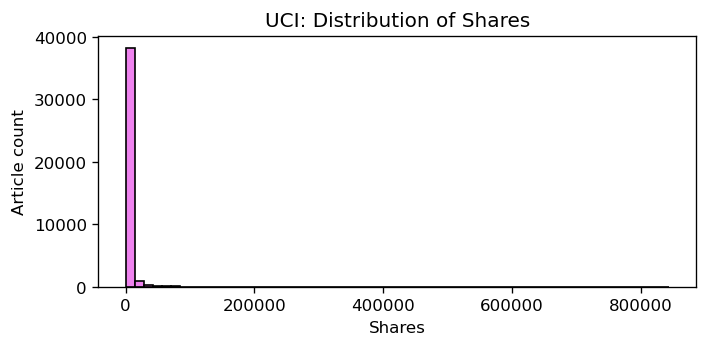

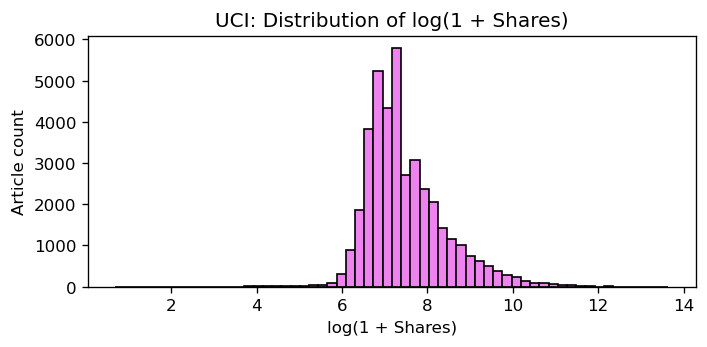

In [7]:
# UCI Plots

# histogram - shares (raw)

fig1, ax1 = plt.subplots(figsize=(6, 3))
ax1.hist(uci["shares"], bins=60, color="violet", edgecolor="black")
ax1.set_title("UCI: Distribution of Shares")
ax1.set_xlabel("Shares")
ax1.set_ylabel("Article count")
fig1.tight_layout()

fig1_path = os.path.join(fig_dir, "uci_shares_hist.png")
fig1.savefig(fig1_path, dpi=100)
print("Saved:", fig1_path)

#log-transformed shares
fig2, ax2 = plt.subplots(figsize=(6, 3))
ax2.hist(uci["shares_log"], bins=60, color="violet", edgecolor="black")
ax2.set_title("UCI: Distribution of log(1 + Shares)")
ax2.set_xlabel("log(1 + Shares)")
ax2.set_ylabel("Article count")
fig2.tight_layout()

fig2_path = os.path.join(fig_dir, "uci_log_shares_hist.png")
fig2.savefig(fig2_path, dpi=100)
print("Saved:", fig2_path)


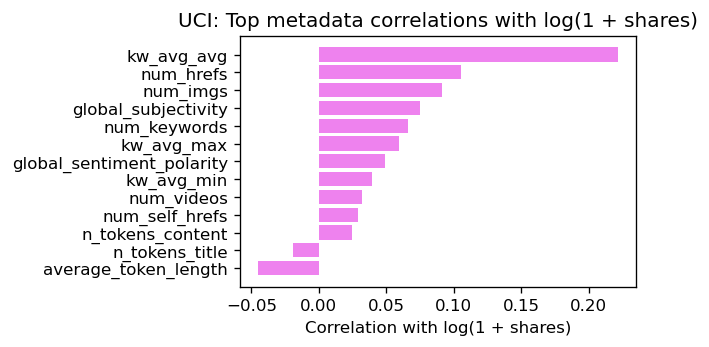

In [8]:
#print(uci.columns.tolist())
import numpy as np

# select metadata columns commonly used in UCI research
meta_cols = [
    "n_tokens_title",
    "n_tokens_content",
    "num_imgs",
    "num_videos",
    "num_hrefs",
    "num_self_hrefs",
    "num_keywords",
    "average_token_length",
    "global_subjectivity",
    "global_sentiment_polarity",
    "kw_avg_min",
    "kw_avg_max",
    "kw_avg_avg"
]

meta_cols = [c for c in meta_cols if c in uci.columns]

uci_meta = uci[meta_cols + ["shares_log"]].dropna()

# correlation matrix
corr_mat = uci_meta.corr(method="pearson")
corr_mat.to_csv(
    os.path.join(fig_dir, "uci_meta_corr_matrix.csv"),
    index=True
)
# sort correlations with log(1 + shares)
target_corr = (
    corr_mat["shares_log"]
    .drop(labels=["shares_log"])
    .sort_values(ascending=False)
)

top_k = 15
top_corr = target_corr.head(top_k).reset_index()
top_corr.columns = ["feature", "correlation"]

# bar chart
fig3, ax3 = plt.subplots(figsize=(5.5, 3))
ax3.barh(top_corr["feature"], top_corr["correlation"], color="violet")
ax3.set_xlabel("Correlation with log(1 + shares)")
ax3.set_title("UCI: Top metadata correlations with log(1 + shares)")
ax3.invert_yaxis()  
fig3.tight_layout()
fig3.savefig(
    os.path.join(fig_dir, "uci_top_corr_log_shares.png"),
    dpi=150,
    bbox_inches="tight"
)

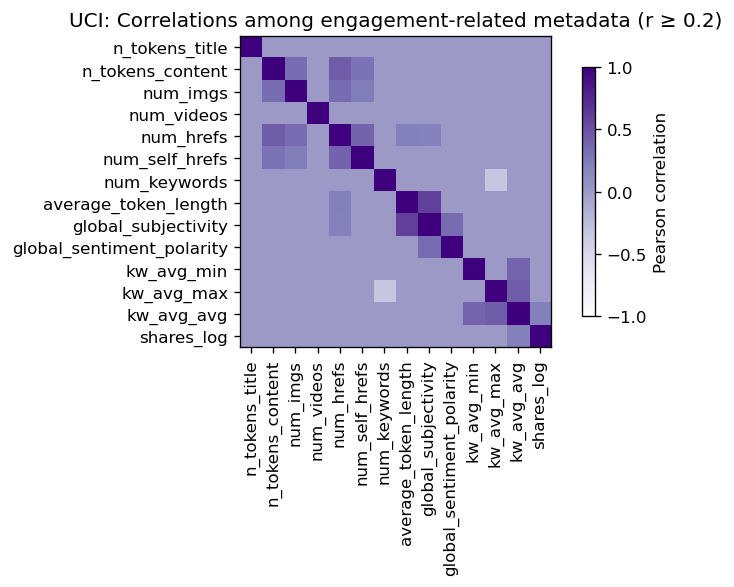

In [9]:
# assign threshold in absolute value
threshold = 0.2
corr_filtered = corr_mat.where(corr_mat.abs() >= threshold)
corr_plot = corr_filtered.fillna(0)

fig4, ax4 = plt.subplots(figsize=(7, 5))
cax = ax4.imshow(corr_plot.values, cmap="Purples", vmin=-1, vmax=1)

ax4.set_xticks(range(len(corr_plot.columns)))
ax4.set_xticklabels(corr_plot.columns, rotation=90)
ax4.set_yticks(range(len(corr_plot.index)))
ax4.set_yticklabels(corr_plot.index)

ax4.set_title("UCI: Correlations among engagement-related metadata (r ≥ 0.2)")
fig4.colorbar(cax, label="Pearson correlation", shrink=0.8)
fig4.tight_layout()

fig4.savefig(
    os.path.join(fig_dir, "uci_meta_corr_heatmap.png"),
    dpi=150,
    bbox_inches="tight"
)

Saved: C:\Users\Evan\Desktop\Capstone\figs\uci_top_corr_with_logshares.png


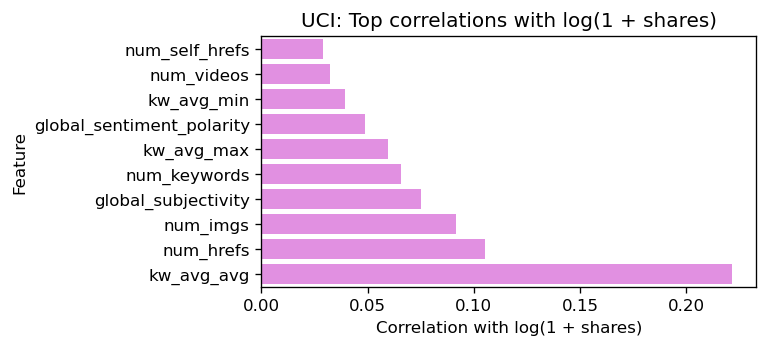

In [10]:
import numpy as np
import pandas as pd
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import os

meta_cols = [
    "n_tokens_title",
    "n_tokens_content",
    "num_imgs",
    "num_videos",
    "num_hrefs",
    "num_self_hrefs",
    "num_keywords",
    "average_token_length",
    "global_subjectivity",
    "global_sentiment_polarity",
    "kw_avg_min",
    "kw_avg_max",
    "kw_avg_avg",
]

# remove NAs and run correlation matrix
uci_meta = (
    uci[meta_cols + ["shares_log"]]
    .dropna()
)
corr = uci_meta.corr()

# sort and retain top ten
target_corr = corr["shares_log"].sort_values(ascending=False)
N = 10
top_corr = target_corr.drop(labels=["shares_log"]).head(N)

cor_df = (
    pd.DataFrame({
        "feature": top_corr.index,
        "correlation": top_corr.values
    })
    .sort_values("correlation", ascending=True)  
)

# plot
plt.figure(figsize=(6.5, 3))
sns.barplot(
    data=cor_df,
    x="correlation",
    y="feature",
    color="violet"
)

plt.title("UCI: Top correlations with log(1 + shares)")
plt.xlabel("Correlation with log(1 + shares)")
plt.ylabel("Feature")

plt.tight_layout()
out_path = os.path.join(fig_dir, "uci_top_corr_with_logshares.png")
plt.savefig(out_path, dpi=100)
#plt.close()

print(f"Saved: {out_path}")


In [11]:
# train a model and generate partial dependence plot

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

feature_cols = [
    "n_tokens_title",
    "n_tokens_content",
    "num_imgs",
    "num_videos",
    "num_hrefs",
    "num_self_hrefs",
    "num_keywords",
    "average_token_length",
    "global_subjectivity",
    "global_sentiment_polarity",
    "kw_avg_min",
    "kw_avg_max",
    "kw_avg_avg"
]

# drop rows with invalid data
model_df = uci.dropna(subset=feature_cols + ["shares_log_wins"]).copy()

X = model_df[feature_cols].values
y = model_df["shares_log_wins"].values


In [12]:

#train random forest baseline

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# edit check
from sklearn.metrics import mean_squared_error, r2_score

y_pred = rf.predict(X_test)

# circumvent old sklearn version that do not support squared=
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
#rmse = mean_squared_error(y_test, y_pred, squared=False)
#r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE (log scale): {rmse:.3f}")
print(f"Random Forest R^2 (log scale):  {r2:.3f}")

Random Forest RMSE (log scale): 0.853
Random Forest R^2 (log scale):  0.112


Saved PDP for global_subjectivity: C:\Users\Evan\Desktop\Capstone\figs\uci_pdp_global_subjectivity.png
Saved PDP for num_imgs: C:\Users\Evan\Desktop\Capstone\figs\uci_pdp_num_imgs.png


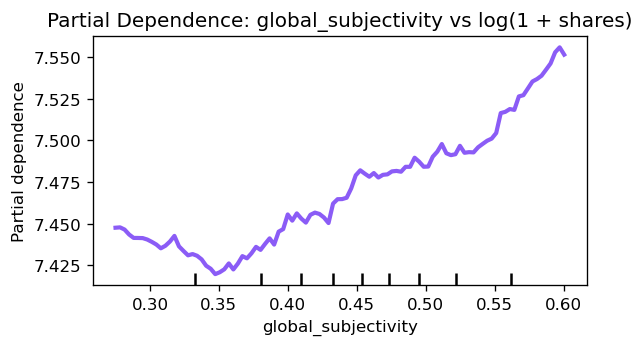

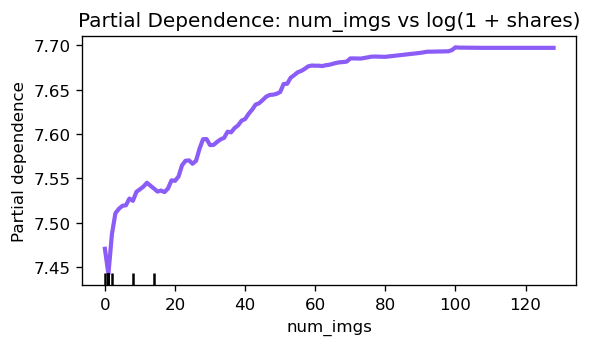

In [13]:
# Partial dependence for global_subjectivity and num_imgs
feat_to_idx = {name: i for i, name in enumerate(feature_cols)}

subjectivity_idx = feat_to_idx["global_subjectivity"]
num_imgs_idx = feat_to_idx["num_imgs"]

# pdpd for global subjectivity

fig_pdp1, ax_pdp1 = plt.subplots(figsize=(5, 3))

PartialDependenceDisplay.from_estimator(
    rf,
    X_train,
    [subjectivity_idx],
    feature_names=feature_cols,
    ax=ax_pdp1,
    line_kw={"color": "#8B5CF6", "linewidth": 2.5}
)

ax_pdp1.set_title("Partial Dependence: global_subjectivity vs log(1 + shares)")
ax_pdp1.set_ylabel("Predicted log(1 + shares)")

fig_pdp1.tight_layout()
pdp1_path = os.path.join(fig_dir, "uci_pdp_global_subjectivity.png")
fig_pdp1.savefig(pdp1_path, dpi=100, bbox_inches="tight")
print(f"Saved PDP for global_subjectivity: {pdp1_path}")

# pdp for num_imgs
fig_pdp2, ax_pdp2 = plt.subplots(figsize=(5, 3))

PartialDependenceDisplay.from_estimator(
    rf,
    X_train,
    [num_imgs_idx],
    feature_names=feature_cols,
    ax=ax_pdp2,
    line_kw={"color": "#8B5CF6", "linewidth": 2.5}
)

ax_pdp2.set_title("Partial Dependence: num_imgs vs log(1 + shares)")
ax_pdp2.set_ylabel("Predicted log(1 + shares)")

fig_pdp2.tight_layout()
pdp2_path = os.path.join(fig_dir, "uci_pdp_num_imgs.png")
fig_pdp2.savefig(pdp2_path, dpi=100, bbox_inches="tight")
print(f"Saved PDP for num_imgs: {pdp2_path}")

In [14]:
# extract metadata feature set and winsorize
X_meta = uci[meta_cols].copy()
y = uci["shares_log_wins"].copy()

# drop missing values
mask = X_meta.notna().all(axis=1) & y.notna()
X_meta = X_meta[mask]
y = y[mask]

# tt split
X_train, X_test, y_train, y_test = train_test_split(
    X_meta, y, test_size=0.2, random_state=123
)

In [15]:
# fit gradient boosting on metadata
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=123
)

gb_model.fit(X_train, y_train)


,loss,'squared_error'
,learning_rate,0.05
,n_estimators,300
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [16]:
importances = gb_model.feature_importances_
feat_importances = pd.DataFrame(
    {"feature": X_meta.columns, "importance": importances}
).sort_values("importance", ascending=False)

top10 = feat_importances.head(10)

top10

,feature,importance
12,kw_avg_avg,0.479973
11,kw_avg_max,0.077370
1,n_tokens_content,0.065235
2,num_imgs,0.058901
10,kw_avg_min,0.058265
4,num_hrefs,0.057311
7,average_token_length,0.047334
8,global_subjectivity,0.044180
9,global_sentiment_polarity,0.033965
6,num_keywords,0.024646


Saved Figure 7 to: C:\Users\Evan\Desktop\Capstone\figs\uci_gb_meta_importances_top10.png


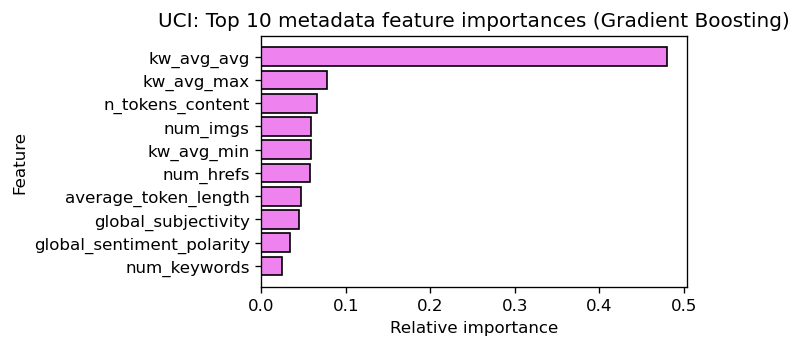

In [17]:
#plot top 10
fig7, ax7 = plt.subplots(figsize=(6, 3))

ax7.barh(
    y=top10["feature"][::-1],
    width=top10["importance"][::-1],
    color="violet",
    edgecolor="black"
)

ax7.set_title("UCI: Top 10 metadata feature importances (Gradient Boosting)")
ax7.set_xlabel("Relative importance")
ax7.set_ylabel("Feature")

fig7.tight_layout()

fig7_path = os.path.join(fig_dir, "uci_gb_meta_importances_top10.png")
fig7.savefig(fig7_path, dpi=100, bbox_inches="tight")

print("Saved Figure 7 to:", fig7_path)

In [18]:
# fit baseline linear regression - gradient boosting model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# predictions
y_pred_lin = lin_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)  

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    #rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

lin_rmse, lin_mae, lin_r2 = compute_metrics(y_test, y_pred_lin)
gb_rmse, gb_mae, gb_r2 = compute_metrics(y_test, y_pred_gb)

Saved model summary table to: C:\Users\Evan\Desktop\Capstone\figs\uci_model_summary_table.csv


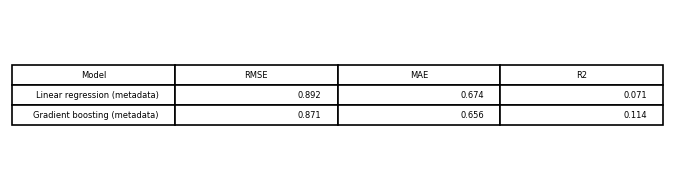

In [19]:
#summary table
summary_df = pd.DataFrame(
    {
        "Model": ["Linear regression (metadata)", "Gradient boosting (metadata)"],
        "RMSE": [lin_rmse, gb_rmse],
        "MAE": [lin_mae, gb_mae],
        "R2": [lin_r2, gb_r2],
    }
)
table_path = os.path.join(fig_dir, "uci_model_summary_table.csv")
summary_df.to_csv(table_path, index=False)
print("Saved model summary table to:", table_path)
summary_rounded = summary_df.copy()
summary_rounded[["RMSE", "MAE", "R2"]] = summary_rounded[["RMSE", "MAE", "R2"]].round(3)

summary_df
n_rows = len(summary_rounded)
fig_height = 1 + 0.4 * n_rows  

fig, ax = plt.subplots(figsize=(7, fig_height))
ax.axis("off")

table = ax.table(
    cellText=summary_rounded.values,
    colLabels=summary_rounded.columns,
    loc="center"
)


In [20]:
# using log(1+shares) as target

#print(uci.columns)

# confirm target and virality exist, using log(1+shares) as target, create virality score


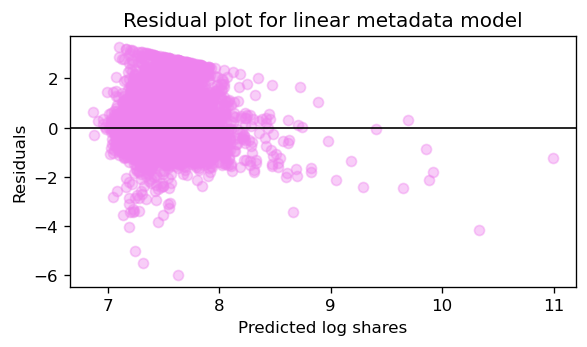

In [21]:
# pull in true and pred from linear regression model
residuals = y_test - y_pred_lin

plt.figure(figsize=(5,3))
plt.scatter(y_pred_lin, residuals, alpha=0.4, color='violet')
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Predicted log shares")
plt.ylabel("Residuals")
plt.title("Residual plot for linear metadata model")
plt.tight_layout()

plt.savefig(r"C:\Users\Evan\Desktop\Capstone\figs\uci_linear_residuals.png", dpi=100)
plt.show()

In [22]:
# Linking and loading MIND behaviors and news to article text
dev_dir = "MINDsmall_dev"
dev_news = pd.read_csv(os.path.join(dev_dir, "dev_news.tsv"),
                       sep="\t", engine="python", quoting=3)
dev_behaviors = pd.read_csv(os.path.join(dev_dir, "dev_behaviors.tsv"),
                            sep="\t", engine="python", quoting=3)
train_dir = "MINDsmall_train"
train_news = pd.read_csv(os.path.join(train_dir, "train_news.tsv"),
                         sep="\t", engine="python", quoting=3)
train_behaviors = pd.read_csv(os.path.join(train_dir, "train_behaviors.tsv"),
                              sep="\t", engine="python", quoting=3)




In [23]:
# files need headers
behaviors_cols = ["impression_id", "user_id", "time", "history", "impressions"]
news_cols = ["news_id",
        "category",
        "subcategory",
        "title",
        "abstract",
        "url",
        "title_entities",
        "abstract_entities",]

train_behaviors = pd.read_csv(os.path.join(train_dir, "train_behaviors.tsv"),
                              sep="\t", header=None, names=behaviors_cols,
                              engine="python", quoting=3)

dev_behaviors = pd.read_csv(os.path.join(dev_dir, "dev_behaviors.tsv"),
                            sep="\t", header=None, names=behaviors_cols,
                            engine="python", quoting=3)

train_news = pd.read_csv(os.path.join(train_dir, "train_news.tsv"),
                              sep="\t", header=None, names=news_cols,
                              engine="python", quoting=3)

dev_news = pd.read_csv(os.path.join(dev_dir, "dev_news.tsv"),
                            sep="\t", header=None, names=news_cols,
                            engine="python", quoting=3)

print("Train behaviors columns:", train_behaviors.columns.tolist())
print("Dev behaviors columns:", dev_behaviors.columns.tolist())
print("Train news columns:", train_news.columns.tolist())
print("Dev news columns:", dev_news.columns.tolist())
#print(train_behaviors.head(2))
#print(dev_behaviors.head(2))

Train behaviors columns: ['impression_id', 'user_id', 'time', 'history', 'impressions']
Dev behaviors columns: ['impression_id', 'user_id', 'time', 'history', 'impressions']
Train news columns: ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']
Dev news columns: ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']


In [24]:
print("Train news:", train_news.shape)
print("Train behaviors:", train_behaviors.shape)
print("Dev news:", dev_news.shape)
print("Dev behaviors:", dev_behaviors.shape)


Train news: (51282, 8)
Train behaviors: (156965, 5)
Dev news: (42416, 8)
Dev behaviors: (73152, 5)


In [25]:
def explode_impressions(df_behaviors, set_name="train", max_rows=None):
    if max_rows is not None:
        df_behaviors = df_behaviors.head(max_rows).copy()

    records = []
    for _, row in df_behaviors.iterrows():
        impress_str = row["impressions"]
        imp_id = row["impression_id"]
        user = row["user_id"]
        time = row["time"]
        for token in impress_str.split():
            news_id, label_str = token.rsplit("-", 1)
            clicked = int(label_str)
            records.append(
                {
                    "set": set_name,
                    "impression_id": imp_id,
                    "user_id": user,
                    "time": time,
                    "news_id": news_id,
                    "clicked": clicked
                }
            )
    return pd.DataFrame.from_records(records)

In [26]:
#check
train_impressions = explode_impressions(train_behaviors,
                                        set_name="train",
                                        max_rows=5000)
dev_impressions = explode_impressions(dev_behaviors,
                                      set_name="dev",
                                      max_rows=3000)

train_impressions.head()
dev_impressions.head()

,set,impression_id,user_id,time,news_id,clicked
0,dev,1,U80234,11/15/2019 12:37:50 PM,N28682,0
1,dev,1,U80234,11/15/2019 12:37:50 PM,N48740,0
2,dev,1,U80234,11/15/2019 12:37:50 PM,N31958,1
3,dev,1,U80234,11/15/2019 12:37:50 PM,N34130,0
4,dev,1,U80234,11/15/2019 12:37:50 PM,N6916,0


In [27]:
for name, df in [
    ("train_impressions", train_impressions),
    ("dev_impressions", dev_impressions),
    ("train_news", train_news),
    ("dev_news", dev_news),
]:
    print(f"{name} columns:", list(df.columns))

train_impressions columns: ['set', 'impression_id', 'user_id', 'time', 'news_id', 'clicked']
dev_impressions columns: ['set', 'impression_id', 'user_id', 'time', 'news_id', 'clicked']
train_news columns: ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']
dev_news columns: ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']


In [28]:
#Join impressions + news metadata, runTF-IDF baseline

# Merge impressions and metadata
train_merged = train_impressions.merge(
    train_news, left_on="news_id", right_on="news_id", how="left"
)
dev_merged = dev_impressions.merge(
    dev_news, left_on="news_id", right_on="news_id", how="left"
)

print("Train merged shape:", train_merged.shape)
print("Dev merged shape:", dev_merged.shape)

train_merged.head()

Train merged shape: (187715, 13)
Dev merged shape: (110621, 13)


,set,impression_id,user_id,time,news_id,clicked,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,train,1,U13740,11/11/2019 9:05:58 AM,N55689,1,sports,football_nfl,"Charles Rogers, former Michigan State football...","Charles Rogers, the former Michigan State foot...",https://assets.msn.com/labs/mind/BBWAPO6.html,"[{""Label"": ""Charles Rogers (American football)...","[{""Label"": ""2003 NFL Draft"", ""Type"": ""U"", ""Wik..."
1,train,1,U13740,11/11/2019 9:05:58 AM,N35729,0,news,newsus,Porsche launches into second story of New Jers...,The Porsche went airborne off a median in Toms...,https://assets.msn.com/labs/mind/BBWyjM9.html,"[{""Label"": ""Porsche"", ""Type"": ""O"", ""WikidataId...","[{""Label"": ""Porsche"", ""Type"": ""O"", ""WikidataId..."
2,train,2,U91836,11/12/2019 6:11:30 PM,N20678,0,sports,more_sports,Bode Miller delivered his twin boys after midw...,Bode Miller added yet another impressive title...,https://assets.msn.com/labs/mind/BBWERWB.html,"[{""Label"": ""Bode Miller"", ""Type"": ""P"", ""Wikida...","[{""Label"": ""Bode Miller"", ""Type"": ""P"", ""Wikida..."
3,train,2,U91836,11/12/2019 6:11:30 PM,N39317,0,news,newspolitics,"Senior Trump official embellished résumé, had ...",State Dept. official Mina Chang claimed to be ...,https://assets.msn.com/labs/mind/BBWEmIj.html,"[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid...","[{""Label"": ""Harvard Business School"", ""Type"": ..."
4,train,2,U91836,11/12/2019 6:11:30 PM,N58114,0,autos,autosnews,2020 Ford Explorer launch hardly went accordin...,NaN,https://assets.msn.com/labs/mind/BBWEGnz.html,"[{""Label"": ""Ford Explorer"", ""Type"": ""V"", ""Wiki...",[]


In [29]:
#create combined text from title and abstract columns since dataset doesn't include full text
train_merged["combined_text"] = (
    train_merged["title"].fillna("") + " " + train_merged["abstract"].fillna("")
)

dev_merged["combined_text"] = (
    dev_merged["title"].fillna("") + " " + dev_merged["abstract"].fillna("")
)

In [30]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
train_text = train_merged.dropna(subset=["title"]).copy()

# tf-idf, features capped
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)
X_train_tfidf = tfidf.fit_transform(train_text["title"])
y_train = train_text["clicked"]

# tt split for baseline
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=123
)

clf = LogisticRegression(max_iter=200)
clf.fit(X_tr, y_tr)

#predictions
val_pred = clf.predict(X_val)

#performance
acc_train  = accuracy_score(y_val, val_pred)
prec_train = precision_score(y_val, val_pred)
rec_train  = recall_score(y_val, val_pred)
f1_train   = f1_score(y_val, val_pred)

print("TF-IDF Title Baseline - Train Split Validation")
print(f"Accuracy:  {acc_train:.4f}")
print(f"Precision: {prec_train:.4f}")
print(f"Recall:    {rec_train:.4f}")
print(f"F1 Score:  {f1_train:.4f}")

TF-IDF Title Baseline - Train Split Validation
Accuracy:  0.9596
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000


C:\Users\Evan\anaconda3.1\envs\capstone310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [31]:
#apply to model devset - filter missing titles
dev_text = dev_merged.dropna(subset=["title"]).copy()

X_dev_tfidf = tfidf.transform(dev_text["title"])
dev_pred = clf.predict(X_dev_tfidf)

acc_dev = accuracy_score(dev_text["clicked"], dev_pred)
prec_dev = precision_score(dev_text["clicked"], dev_pred)
rec_dev  = recall_score(dev_text["clicked"], dev_pred)
f1_dev  = f1_score(dev_text["clicked"], dev_pred)

print("TF-IDF Title Baseline - Applied to Dev Set")
print(f"Accuracy:  {acc_dev:.4f}")
print(f"Precision: {prec_dev:.4f}")
print(f"Recall:    {rec_dev:.4f}")
print(f"F1 Score:  {f1_dev:.4f}")

TF-IDF Title Baseline - Applied to Dev Set
Accuracy:  0.9589
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000


C:\Users\Evan\anaconda3.1\envs\capstone310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Saved figure to: C:\Users\Evan\Desktop\Capstone\figs\mind_tfidf_title_baseline_metrics.png


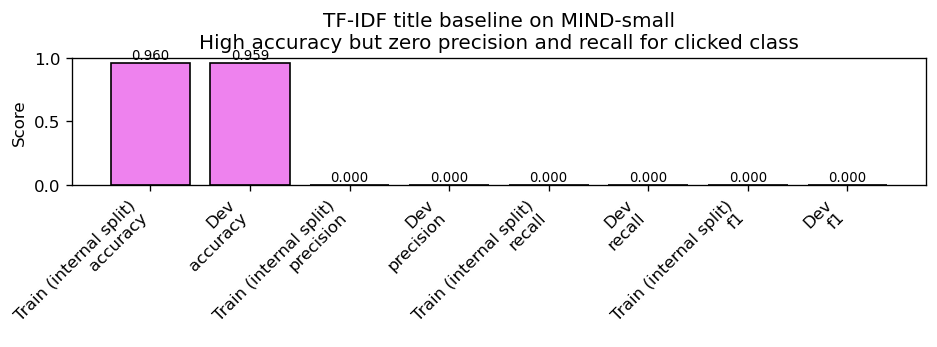

In [32]:
#display numbers in paper
fig_dir = r"C:\Users\Evan\Desktop\Capstone\figs"
os.makedirs(fig_dir, exist_ok=True)

mind_results = pd.DataFrame({
    "set": ["Train (internal split)", "Dev"],
    "accuracy": [0.9596, 0.9589],
    "precision": [0.0, 0.0],
    "recall": [0.0, 0.0],
    "f1": [0.0, 0.0]
})

mind_results.to_csv(
    os.path.join(fig_dir, "mind_tfidf_title_baseline_metrics.csv"),
    index=False
)

plt.close("all")

mind_long = mind_results.melt(
    id_vars="set",
    value_vars=["accuracy", "precision", "recall", "f1"],
    var_name="metric",
    value_name="score"
)

fig9, ax = plt.subplots(figsize=(8, 3))
x_positions = range(len(mind_long))
bars = ax.bar(
    x_positions,
    mind_long["score"],
    color="violet",
    edgecolor="black"
)

ax.set_xticks(x_positions)
ax.set_xticklabels(
    [f"{row.set}\n{row.metric}" for _, row in mind_long.iterrows()],
    rotation=45,
    ha="right"
)

ax.set_ylim(0, 1.0)
ax.set_ylabel("Score")
ax.set_title(
    "TF-IDF title baseline on MIND-small\n"
    "High accuracy but zero precision and recall for clicked class"
)
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

fig9.tight_layout()
out_path = os.path.join(fig_dir, "mind_tfidf_title_baseline_metrics.png")
fig9.savefig(out_path, dpi=150, bbox_inches="tight")
print("Saved figure to:", out_path)

'C:\\Users\\Evan\\Desktop\\Capstone\\figs\\figure10_tfidf_table.png'

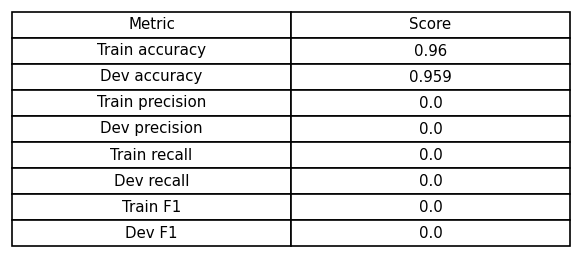

In [33]:
data = {
    "Metric": [
        "Train accuracy",
        "Dev accuracy",
        "Train precision",
        "Dev precision",
        "Train recall",
        "Dev recall",
        "Train F1",
        "Dev F1"
    ],
    "Score": [0.960, 0.959, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
}

df_table = pd.DataFrame(data)
#table
fig10, ax = plt.subplots(figsize=(6, 2))
ax.axis("off")
tbl = ax.table(
    cellText=df_table.values,
    colLabels=df_table.columns,
    loc="center",
    cellLoc="center"
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1, 1.3)
fig_path = r"C:\Users\Evan\Desktop\Capstone\figs\figure10_tfidf_table.png"
plt.savefig(fig_path, dpi=150, bbox_inches="tight")

fig_path

In [34]:
#train_merged.head

In [35]:
# my evaluation cell below failed due to filtering, correcting here
train_text_df = train_merged.copy()
dev_text_df = dev_merged.copy()

# keep records with text
train_text_df = train_text_df[
    train_text_df["title"].notna() | train_text_df["abstract"].notna()
]
dev_text_df = dev_text_df[
    dev_text_df["title"].notna() | dev_text_df["abstract"].notna()
]

# combine title / abstract
train_text = (
    train_text_df["title"].fillna("") + " " + train_text_df["abstract"].fillna("")
)
dev_text = (
    dev_text_df["title"].fillna("") + " " + dev_text_df["abstract"].fillna("")
)

# TF-IDF vectorizer 
vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=5
)
X_train_tfidf = vectorizer.fit_transform(train_text)
X_dev_tfidf = vectorizer.transform(dev_text)
y_train = train_text_df["clicked"].astype(int).values
y_dev = dev_text_df["clicked"].astype(int).values
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("len(y_train):", len(y_train))
print("X_dev_tfidf shape:", X_dev_tfidf.shape)
print("len(y_dev):", len(y_dev))

X_train_tfidf shape: (187715, 50000)
len(y_train): 187715
X_dev_tfidf shape: (110621, 50000)
len(y_dev): 110621


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# stratified internal validation split from train set
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_tfidf,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

# fit logistic regression on the sub-train
tfidf_clf_final = LogisticRegression(
    max_iter=1000,
    class_weight=None,
    n_jobs=-1
)
tfidf_clf_final.fit(X_train_sub, y_train_sub)


def evaluate_model(y_true, y_pred, prefix=""):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"{prefix}Confusion matrix:")
    print(cm)
    print(f"{prefix}TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"{prefix}Accuracy:  {acc:.4f}")
    print(f"{prefix}Precision: {prec:.4f}")
    print(f"{prefix}Recall:    {rec:.4f}")
    print(f"{prefix}F1 Score:  {f1:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }


print("TF-IDF title + abstract baseline on MIND-small\n")

print("Internal train split validation:")
metrics_val = evaluate_model(
    y_val_sub,
    tfidf_clf_final.predict(X_val_sub),
    prefix="  "
)

print("\nHeld-out dev set:")
metrics_dev = evaluate_model(
    y_dev,
    tfidf_clf_final.predict(X_dev_tfidf),
    prefix="  "
)

# summary table
summary_df = pd.DataFrame(
    [
        {
            "Split": "Train internal validation",
            "Accuracy": metrics_val["accuracy"],
            "Precision": metrics_val["precision"],
            "Recall": metrics_val["recall"],
            "F1": metrics_val["f1"],
        },
        {
            "Split": "Dev (held-out)",
            "Accuracy": metrics_dev["accuracy"],
            "Precision": metrics_dev["precision"],
            "Recall": metrics_dev["recall"],
            "F1": metrics_dev["f1"],
        }
    ]
)

summary_display = summary_df.copy()
summary_display[["Accuracy", "Precision", "Recall", "F1"]] = summary_display[
    ["Accuracy", "Precision", "Recall", "F1"]
].round(4)

print("\nTF-IDF baseline performance summary:")
print(summary_display)

TF-IDF title + abstract baseline on MIND-small

Internal train split validation:
  Confusion matrix:
[[36036     0]
 [ 1507     0]]
  TN=36036, FP=0, FN=1507, TP=0
  Accuracy:  0.9599
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000

Held-out dev set:
  Confusion matrix:
[[106070      0]
 [  4551      0]]
  TN=106070, FP=0, FN=4551, TP=0
  Accuracy:  0.9589
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000

TF-IDF baseline performance summary:
                       Split  Accuracy  Precision  Recall   F1
0  Train internal validation    0.9599        0.0     0.0  0.0
1             Dev (held-out)    0.9589        0.0     0.0  0.0


Saved table figure to: C:\Users\Evan\Desktop\Capstone\figs\mind_tfidf_baseline_table.png


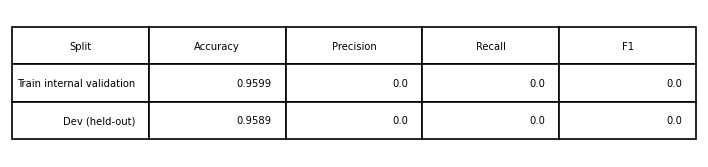

In [37]:
# Plot and save
fig11, ax = plt.subplots(figsize=(6, 1.5))
ax.axis("off")
table = ax.table(
    cellText=summary_display.values,
    colLabels=summary_display.columns,
    loc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1, 1.8)

fig11.tight_layout()
table_path = os.path.join(fig_dir, "mind_tfidf_baseline_table.png")
fig11.savefig(table_path, dpi=150, bbox_inches="tight")
print(f"Saved table figure to: {table_path}")

In [38]:
from sklearn.decomposition import TruncatedSVD

# combine title and abstrack before building TF-IDF matrix
train_merged["text_concat"] = (
    train_merged["title"].fillna("") + " " + train_merged["abstract"].fillna("")
)
dev_merged["text_concat"] = (
    dev_merged["title"].fillna("") + " " + dev_merged["abstract"].fillna("")
)
tfidf_text = TfidfVectorizer(
    max_features=50000,
    stop_words="english"
)
X_train_tfidf_text = tfidf_text.fit_transform(train_merged["text_concat"])
X_dev_tfidf_text = tfidf_text.transform(dev_merged["text_concat"])

# reduce dimensionality / produce embedding vectors
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_emb = svd.fit_transform(X_train_tfidf_text)
X_dev_emb = svd.transform(X_dev_tfidf_text)

print("Train embedding shape:", X_train_emb.shape)
print("Dev embedding shape:", X_dev_emb.shape)

Train embedding shape: (187715, 300)
Dev embedding shape: (110621, 300)


In [39]:
y_train = train_merged["clicked"]
y_dev = dev_merged["clicked"]

clf_emb = LogisticRegression(
    max_iter=1000,
    class_weight=None,
    n_jobs=-1
)

clf_emb.fit(X_train_emb, y_train)

# formpredictions and publish metrics
train_pred_emb = clf_emb.predict(X_train_emb)
dev_pred_emb = clf_emb.predict(X_dev_emb)
train_acc = accuracy_score(y_train, train_pred_emb)
train_prec = precision_score(y_train, train_pred_emb, zero_division=0)
train_rec = recall_score(y_train, train_pred_emb, zero_division=0)
train_f1 = f1_score(y_train, train_pred_emb, zero_division=0)
dev_acc = accuracy_score(y_dev, dev_pred_emb)
dev_prec = precision_score(y_dev, dev_pred_emb, zero_division=0)
dev_rec = recall_score(y_dev, dev_pred_emb, zero_division=0)
dev_f1 = f1_score(y_dev, dev_pred_emb, zero_division=0)

print("Embedding baseline — Train set")
print("Accuracy:", train_acc)
print("Precision:", train_prec)
print("Recall:", train_rec)
print("F1:", train_f1)

print("\nEmbedding baseline — Dev set")
print("Accuracy:", dev_acc)
print("Precision:", dev_prec)
print("Recall:", dev_rec)
print("F1:", dev_f1)

Embedding baseline — Train set
Accuracy: 0.9598593612657486
Precision: 0.0
Recall: 0.0
F1: 0.0

Embedding baseline — Dev set
Accuracy: 0.9588595293841133
Precision: 0.0
Recall: 0.0
F1: 0.0


   Split  Accuracy  Precision  Recall   F1
0  Train  0.959859        0.0     0.0  0.0
1    Dev  0.958860        0.0     0.0  0.0


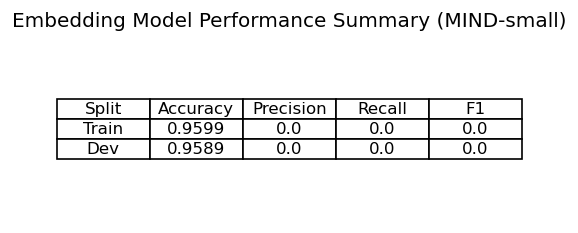

In [40]:
embedding_results = pd.DataFrame({
    "Split": ["Train", "Dev"],
    "Accuracy": [train_acc, dev_acc],
    "Precision": [train_prec, dev_prec],
    "Recall": [train_rec, dev_rec],
    "F1": [train_f1, dev_f1]
})

print(embedding_results)

# produce image
fig_dir = r"C:\Users\Evan\Desktop\Capstone\figs"
os.makedirs(fig_dir, exist_ok=True)

embedding_results.to_csv(
    os.path.join(fig_dir, "mind_embedding_performance.csv"),
    index=False
)

fig12, ax = plt.subplots(figsize=(5, 2))
ax.axis("off")
table = ax.table(
    cellText=embedding_results.round(4).values,
    colLabels=embedding_results.columns,
    cellLoc="center",
    loc="center"
)
plt.title("Embedding Model Performance Summary (MIND-small)")
plt.savefig(
    os.path.join(fig_dir, "mind_embedding_performance.png"),
    dpi=100,
    bbox_inches="tight"
)
plt.show()

In [41]:
import shap

In [42]:
meta_cols = [
    "n_tokens_title",
    "n_tokens_content",
    "num_imgs",
    "num_videos",
    "num_hrefs",
    "num_self_hrefs",
    "num_keywords",
    "average_token_length",
    "global_subjectivity",
    "global_sentiment_polarity",
    "kw_avg_min",
    "kw_avg_max",
    "kw_avg_avg",
]

# featurs, target, and refitting for shap
X_meta = uci[meta_cols].fillna(0)
y_meta = uci["shares_log"]
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_meta, y_meta, test_size=0.2, random_state=42
)
gb_for_shap = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
)
gb_for_shap.fit(X_train_m, y_train_m)

# sample for shap, and run
X_sample = X_test_m.sample(n=2000, random_state=42)
explainer = shap.TreeExplainer(gb_for_shap)
shap_values = explainer.shap_values(X_sample)

# shap summary
plt.figure(figsize=(8, 5))
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=X_sample.columns,
    show=False,
    max_display=15,
    cmap="RdPu"
)
plt.title("SHAP summary: Gradient boosting on UCI metadata")

shap_fig_path = os.path.join(fig_dir, "uci_shap_summary.png")
plt.savefig(shap_fig_path, dpi=150, bbox_inches="tight")
plt.close()

print("Saved SHAP summary to:", shap_fig_path)

Saved SHAP summary to: C:\Users\Evan\Desktop\Capstone\figs\uci_shap_summary.png


In [43]:
# ensure alignment btwn target and feature set
target_col = "shares_log"  
uci_meta = uci[meta_cols + [target_col]].dropna()
X = uci_meta[meta_cols]
y = uci_meta[target_col]
#2 splits
X_s1, _, y_s1, _ = train_test_split(
    X, y, test_size=0.30, random_state=67
)
X_s2, _, y_s2, _ = train_test_split(
    X, y, test_size=0.30, random_state=99
)
#fit
def fit_gbm_and_shap(X_split, y_split, random_state):
    gb = GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=random_state
    )
    gb.fit(X_split, y_split)

    explainer = shap.TreeExplainer(gb)
    shap_values = explainer.shap_values(X_split)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    return mean_abs_shap

mean_abs_s1 = fit_gbm_and_shap(X_s1, y_s1, random_state=67)
mean_abs_s2 = fit_gbm_and_shap(X_s2, y_s2, random_state=99)

Top features by mean SHAP in split 1 vs split 2:


,feature,split_1,split_2
12,kw_avg_avg,0.191912,0.187514
11,kw_avg_max,0.047452,0.053248
4,num_hrefs,0.038727,0.047940
10,kw_avg_min,0.033090,0.027784
2,num_imgs,0.033081,0.037124
1,n_tokens_content,0.031800,0.031839
7,average_token_length,0.027178,0.027544
8,global_subjectivity,0.026088,0.027910
3,num_videos,0.022557,0.019000
9,global_sentiment_polarity,0.021465,0.023896


Saved SHAP stability figure to: C:\Users\Evan\Desktop\Capstone\figs\uci_shap_stability_splits.png


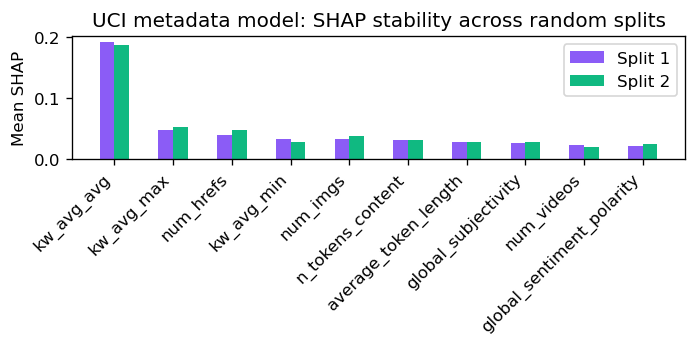

In [44]:
#plot
shap_stability_df = pd.DataFrame({
    "feature": meta_cols,
    "split_1": mean_abs_s1,
    "split_2": mean_abs_s2
})

# sort top 10
shap_stability_top = shap_stability_df.sort_values(
    "split_1", ascending=False
).head(10)

print("Top features by mean SHAP in split 1 vs split 2:")
display(shap_stability_top)

# bar
x = np.arange(len(shap_stability_top))
width = 0.25

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(x - width/2, shap_stability_top["split_1"], width, label="Split 1", color="#8B5CF6")
ax.bar(x + width/2, shap_stability_top["split_2"], width, label="Split 2", color="#10B981")

ax.set_xticks(x)
ax.set_xticklabels(shap_stability_top["feature"], rotation=45, ha="right")
ax.set_ylabel("Mean SHAP")
ax.set_title("UCI metadata model: SHAP stability across random splits")
ax.legend()
fig.tight_layout()
fig_path = os.path.join(fig_dir, "uci_shap_stability_splits.png")
fig.savefig(fig_path, dpi=150, bbox_inches="tight")
print("Saved SHAP stability figure to:", fig_path)

In [45]:
#gradient boosting on UCI metadata / shap 
target_col = "shares_log"
uci_meta = uci[meta_cols + [target_col]].dropna()
X_uci = uci_meta[meta_cols]
y_uci = uci_meta[target_col]

gb_uci = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=123
)
gb_uci.fit(X_uci, y_uci)

explainer_uci = shap.TreeExplainer(gb_uci)
shap_uci = explainer_uci.shap_values(X_uci)

mean_abs_shap_uci = np.abs(shap_uci).mean(axis=0)

uci_importance = pd.DataFrame({
    "feature": meta_cols,
    "mean_abs_shap": mean_abs_shap_uci
}).sort_values("mean_abs_shap", ascending=False)

# to 10
uci_top = uci_importance.head(10)

print("Top UCI metadata features by mean SHAP")
display(uci_top)

Top UCI metadata features by mean SHAP


,feature,mean_abs_shap
12,kw_avg_avg,0.193136
11,kw_avg_max,0.048269
4,num_hrefs,0.037407
2,num_imgs,0.036630
8,global_subjectivity,0.032941
1,n_tokens_content,0.032809
10,kw_avg_min,0.029249
5,num_self_hrefs,0.025743
7,average_token_length,0.023691
9,global_sentiment_polarity,0.022830


In [46]:
# MIND title, abstract features, and shap importances, starting with text features puilled from sample
mind_df = train_merged[["title", "abstract", "clicked"]].dropna().copy()
mind_df["title_len"] = mind_df["title"].str.len()
mind_df["abstract_len"] = mind_df["abstract"].str.len()
mind_df["title_words"] = mind_df["title"].str.split().str.len()
mind_df["abstract_words"] = mind_df["abstract"].str.split().str.len()
mind_feature_cols = ["title_len", "abstract_len", "title_words", "abstract_words"]
X_mind_full = mind_df[mind_feature_cols]
y_mind_full = mind_df["clicked"].astype(int)

sample_size = min(50000, len(mind_df))
mind_sample = mind_df.sample(sample_size, random_state=123)
X_mind = mind_sample[mind_feature_cols]
y_mind = mind_sample["clicked"].astype(int)
gb_mind = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=123
)
gb_mind.fit(X_mind, y_mind)
explainer_mind = shap.TreeExplainer(gb_mind)

shap_mind_all = explainer_mind.shap_values(X_mind)
shap_mind_pos = shap_mind_all[1]
mean_abs_shap_mind = np.abs(shap_mind_pos).mean(axis=0)

mind_importance = pd.DataFrame({
    "feature": mind_feature_cols,
    "mean_abs_shap": mean_abs_shap_mind
}).sort_values("mean_abs_shap", ascending=False)

print("MIND simple text features by mean SHAP (clicked class):")
display(mind_importance)

MIND simple text features by mean SHAP (clicked class):


,feature,mean_abs_shap
0,title_len,0.108748
1,abstract_len,0.108748
2,title_words,0.108748
3,abstract_words,0.108748


Saved comparison figure to: C:\Users\Evan\Desktop\Capstone\figs\uci_vs_mind_shap_importance.png


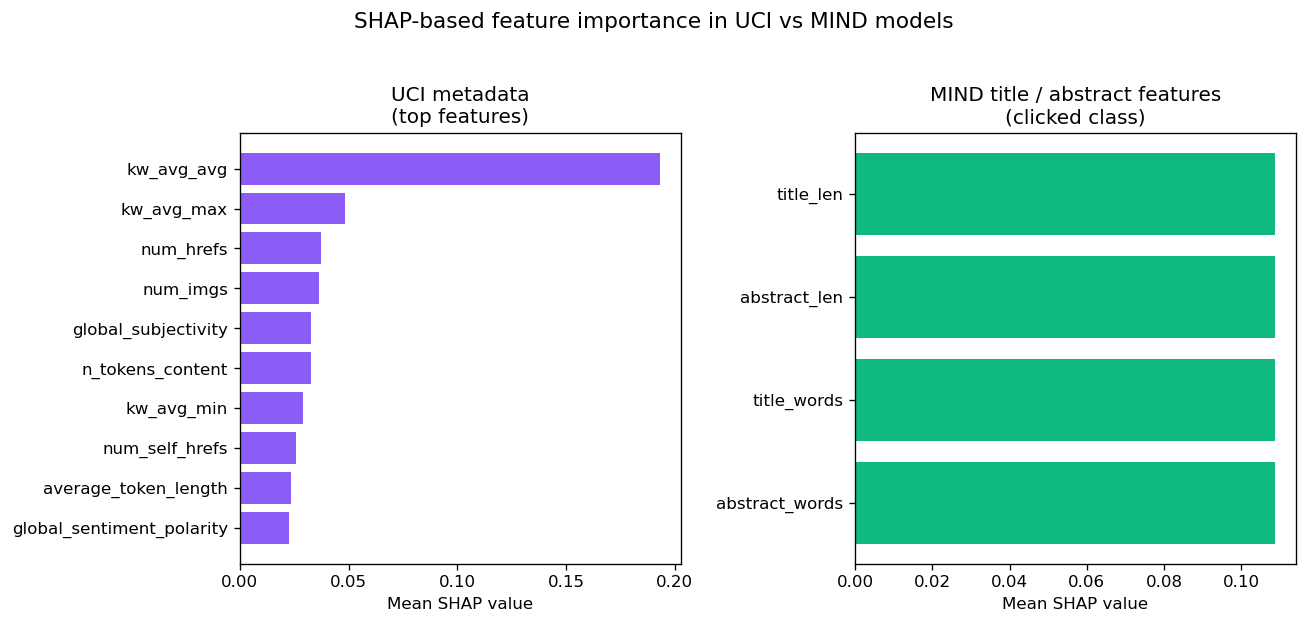

In [47]:
#plots: UCI metadata vs MIND simple text features

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

axes[0].barh(
    y=np.arange(len(uci_top)),
    width=uci_top["mean_abs_shap"].values,
    color="#8B5CF6"
)
axes[0].set_yticks(np.arange(len(uci_top)))
axes[0].set_yticklabels(uci_top["feature"])
axes[0].invert_yaxis()
axes[0].set_xlabel("Mean SHAP value")
axes[0].set_title("UCI metadata\n(top features)")

axes[1].barh(
    y=np.arange(len(mind_importance)),
    width=mind_importance["mean_abs_shap"].values,
    color="#10B981"
)
axes[1].set_yticks(np.arange(len(mind_importance)))
axes[1].set_yticklabels(mind_importance["feature"])
axes[1].invert_yaxis()
axes[1].set_xlabel("Mean SHAP value")
axes[1].set_title("MIND title / abstract features\n(clicked class)")

fig.suptitle(
    "SHAP-based feature importance in UCI vs MIND models",
    fontsize=13,
    y=1.03
)
fig.tight_layout()

fig_path = os.path.join(fig_dir, "uci_vs_mind_shap_importance.png")
fig.savefig(fig_path, dpi=150, bbox_inches="tight")
print("Saved comparison figure to:", fig_path)

In [77]:
import os
import json
import time
from openai import OpenAI

#os.environ.get("OPENAI_API_KEY")

client = OpenAI()
#save down scored sample
FIG_DIR = r"C:\Users\Evan\Desktop\Capstone\figs"
os.makedirs(FIG_DIR, exist_ok=True)

OUT_CSV = os.path.join(FIG_DIR, "mind_virality_scores_sample.csv")

In [78]:
print("OPENAI_API_KEY set:", os.environ.get("OPENAI_API_KEY") is not None)


OPENAI_API_KEY set: True


In [79]:
# create and pass prompt, narrow json scoring function
SYSTEM_PROMPT = """
You are an expert in digital media, journalism, and online audience behavior.

Task:
Score how likely a news article is to generate strong engagement based only on its title and abstract.

Return JSON that matches the schema exactly.
Be consistent across similar inputs.
"""

# ensure getting exact json
VIRALITY_SCHEMA = {
    "name": "virality_score",
    "strict": True,
    "schema": {
        "type": "object",
        "properties": {
            "score": {
                "type": "integer",
                "minimum": 0,
                "maximum": 100,
                "description": "0 to 100 virality potential"
            },
            "rationale": {
                "type": "string",
                "description": "1 to 3 sentences explaining the score"
            }
        },
        "required": ["score", "rationale"],
        "additionalProperties": False
    }
}

def score_virality_one(text_for_llm: str, model: str = "gpt-4.1-mini") -> dict:
    """
    Returns: {"score": int, "rationale": str}
    Enforces JSON schema so we do not rely on fragile json.loads over freeform text.
    """
    resp = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT.strip()},
            {"role": "user", "content": text_for_llm.strip()}
        ],
        response_format={
            "type": "json_schema",
            "json_schema": VIRALITY_SCHEMA
        },
        temperature=0
    )

    content = resp.choices[0].message.content
    # hopefull fixes persisten json issues
    data = json.loads(content)

    return {
        "score": int(data["score"]),
        "rationale": str(data["rationale"]).strip()
    }

print("SYSTEM_PROMPT exists:", "SYSTEM_PROMPT" in globals())

SYSTEM_PROMPT exists: True


In [80]:
#llm input and create output file
if "news_df" not in globals():
    # You can swap this to dev_news or train_news depending on what you loaded
    news_df = dev_news.copy() if "dev_news" in globals() else train_news.copy()

# columnt check
for col in ["news_id", "title", "abstract"]:
    if col not in news_df.columns:
        raise ValueError(f"Missing column in news_df: {col}. Columns are: {list(news_df.columns)[:20]}")

news_df["title"] = news_df["title"].fillna("").astype(str)
news_df["abstract"] = news_df["abstract"].fillna("").astype(str)

news_df["text_for_llm"] = (
    "Title:\n" + news_df["title"] + "\n\n" +
    "Abstract:\n" + news_df["abstract"] + "\n\n" +
    "Return JSON only."
)

print("news_df shape:", news_df.shape)
news_df[["news_id", "title", "abstract"]].head(3)

news_df shape: (42416, 9)


,news_id,title,abstract
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N18955,Dispose of unwanted prescription drugs during ...,
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...


In [81]:
# score and output fresh file
if os.path.exists(OUT_CSV):
    print("Deleting old OUT_CSV so we can rescore:", OUT_CSV)
    os.remove(OUT_CSV)

n_sample = 200 
sample_df = news_df.sample(n=min(n_sample, len(news_df)), random_state=42).reset_index(drop=True)

rows = []
for i, row in sample_df.iterrows():
    try:
        res = score_virality_one(row["text_for_llm"])
        rows.append({
            "news_id": row["news_id"],
            "title": row["title"],
            "abstract": row["abstract"],
            "virality_score": res["score"],
            "virality_rationale": res["rationale"]
        })
    except Exception as e:
        rows.append({
            "news_id": row.get("news_id"),
            "title": row.get("title"),
            "abstract": row.get("abstract"),
            "virality_score": np.nan,
            "virality_rationale": f"ERROR: {type(e).__name__}: {e}"
        })
        print("---- ERROR ----")
        print("news_id:", row.get("news_id"))
        traceback.print_exc()

    # cushion
    time.sleep(0.15)

    if (i + 1) % 25 == 0:
        print(f"Scored {i+1}/{len(sample_df)}")

scored = pd.DataFrame(rows)
scored.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

scored.head(10)

Scored 25/200
Scored 50/200
Scored 75/200
Scored 100/200
Scored 125/200
Scored 150/200
Scored 175/200
Scored 200/200
Saved: C:\Users\Evan\Desktop\Capstone\figs\mind_virality_scores_sample.csv


,news_id,title,abstract,virality_score,virality_rationale
0,N17981,NFL world loved Rob Gronkowski's debut as analyst,Is there anything he can't do?,65,The article taps into the popularity of Rob Gr...
1,N59867,California lawmakers risk 'gigantic costs' to ...,Transportation is the leading source of carbon...,65,The article addresses a timely and important t...
2,N5083,Michael Irvin: How Cowboys 'May End Up Missing...,Michael Irvin joined WIP and KRLD to discuss t...,65,"The title features a well-known sports figure,..."
3,N41004,Delicious Christmas Breakfast Ideas That'll St...,'Tis the season to enjoy baked French toast.,65,The title appeals to a broad audience interest...
4,N33919,Edina's Southdale Center Announces Slew Of New...,"Don't look now, but the holiday shopping seaso...",45,The article taps into the timely topic of holi...
5,N64035,De Blasio Denies Ordering NYPD Car Service For...,The NYPD took Dante de Blasio to and from Yale...,65,The article touches on a politically charged t...
6,N54988,28 Dumb Ways You Could Lose It All by Trying T...,Don't gamble your money away in foolish ways.,75,The title is provocative and uses a listicle f...
7,N12222,Roughnecks make Connor Cook first draft pick i...,"Quarterback Phillip Walker, who spent parts of...",45,The article appeals primarily to fans of the H...
8,N17637,Denver's South Broadway is going through big c...,The heart of Denver's South Broadway commercia...,65,The article touches on urban development and c...
9,N45488,Magic Johnson defends Michael Jordan over Step...,"In an interview with TODAY's Craig Melvin, NBA...",75,The article involves high-profile NBA figures ...


In [82]:
#score check
scored["virality_score"].describe(), scored["virality_score"].isna().mean()


(count    200.000000
 mean      62.080000
 std       13.493479
 min       15.000000
 25%       55.000000
 50%       65.000000
 75%       75.000000
 max       85.000000
 Name: virality_score, dtype: float64,
 np.float64(0.0))

In [83]:
#set location and assess output
os.makedirs(FIG_DIR, exist_ok=True)
if "scored" not in globals() or scored is None:
    if not os.path.exists(OUT_CSV):
        raise FileNotFoundError(f"Can't find OUT_CSV at: {OUT_CSV}")
    scored = pd.read_csv(OUT_CSV)


In [84]:
#ensure score is numeric and conduct quick edit check
scored["virality_score"] = pd.to_numeric(scored["virality_score"], errors="coerce")
n_total = len(scored)
n_missing = int(scored["virality_score"].isna().sum())
print("Rows:", n_total)
print("Missing virality_score:", n_missing, f"({n_missing / max(n_total,1):.3%})")

Rows: 200
Missing virality_score: 0 (0.000%)


Saved summary CSV: C:\Users\Evan\Desktop\Capstone\figs\mind_virality_score_summary.csv


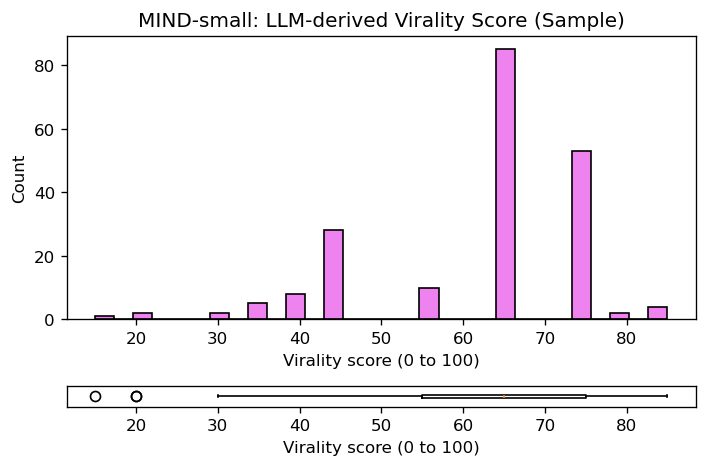

Saved figure: C:\Users\Evan\Desktop\Capstone\figs\mind_virality_score_distribution.png


In [85]:
#summary results
summary = scored["virality_score"].describe().to_frame(name="virality_score").reset_index()
summary.columns = ["stat", "value"]
summary_path = os.path.join(FIG_DIR, "mind_virality_score_summary.csv")
summary.to_csv(summary_path, index=False)
print("Saved summary CSV:", summary_path)

fig = plt.figure(figsize=(6, 4))

# histo
ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=4)
ax1.hist(scored["virality_score"].dropna(), bins=30, color="violet", edgecolor="black")
ax1.set_title("MIND-small: LLM-derived Virality Score (Sample)")
ax1.set_xlabel("Virality score (0 to 100)")
ax1.set_ylabel("Count")

# boxplot
ax2 = plt.subplot2grid((5, 1), (4, 0), rowspan=1)
ax2.boxplot(scored["virality_score"].dropna(), vert=False)
ax2.set_xlabel("Virality score (0 to 100)")
ax2.set_yticks([])

fig.tight_layout()

fig_path = os.path.join(FIG_DIR, "mind_virality_score_distribution.png")
fig.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved figure:", fig_path)